In [2]:
from astropy.table import Table
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from astropy.io import ascii
import matplotlib.pyplot as plt
# from scipy.integrate import quad

# Time range around the horizon crossing
startTime = 390+1.92224*10**8
stopTime = 500+1.92224*10**8

# indices for the event file
startTimeIndex = 311883
stopTimeIndex = 352360

# read in the data files
tab_ni = Table.read('ni2200300102.mkf', hdu=1)
timeArray = np.array(tab_ni['TIME'])
elevArray = np.array(tab_ni['ELV'])
azArray = np.array(tab_ni['RAM_ANGLE'])
enArray_low = np.array(tab_ni['FPM_XRAY_PI_0035_0200'])
enArray_mid = np.array(tab_ni['FPM_XRAY_PI_0800_1200'])

tab_evt = Table.read('cleanfilt.evt', hdu=1)
eventTime = np.array(tab_evt['TIME'][startTimeIndex:stopTimeIndex])
enArray = np.array(tab_evt['PI'][startTimeIndex:stopTimeIndex])


# interpolate the times.evt to go over the range of elevations.mkf
f = interpolate.interp1d(timeArray, elevArray, kind='linear')
elev_evt = f(eventTime)

g = interpolate.interp1d(timeArray, azArray, kind='linear')
az_evt = g(eventTime)

# calculate altitude based on elevation angle
R = 6378
H = 410
theta = np.arcsin(R/(R+H))
altArray = []
for indx, val in enumerate(elev_evt):
    h = ((R+H)*np.sin(theta+val*(np.pi/180)))-R
    altArray.append(np.float(h))
altArray = np.array(altArray)


# read in MSIS model data
data = ascii.read("msis_model.txt")

height = np.array(data['km'])
density = np.array(data['g/cm^3'])
temp = np.array(data['K'])


def msisSync(Y_msis):
    height[0] = altArray[0]
    height[len(height)-1] = altArray[len(altArray)-1]
    func = interpolate.interp1d(height, Y_msis)
    return np.array(func(altArray))


msisRho = msisSync(density)
msisT = msisSync(temp)


# bin size and energy band cutoffs
binSize_all = 1
lowEn = [30, 70]
lowMidEn = [70, 100]
lowMidEn1 = [70, 80]
lowMidEn2 = [80, 90]
lowMidEn3 = [90, 100]
midEn = [100, 200]
highEn = [200, 600]
allEn = [0, 600]


class EnergyBands:

    def __init__(self, energy_band, bin_size):
        self.energy_band = energy_band
        self.bin_size = bin_size
        self.time, self.energies = enSplit(energy_band)
        self.alt = altSplit(energy_band)
        self.rate, self.new_alt = countRate(self.time, self.alt, bin_size)
        self.T_pre = msisSplit(self.alt, energy_band, msisT)
        self.rho_pre = msisSplit(self.alt, energy_band, msisRho)
        self.rho_msis, self.T_msis = countRateSync(self.time, self.alt, self.rho_pre, self.T_pre, bin_size)
        self.time_axis = Axis(self.rate, bin_size)
        self.perc_trans = percTrans(self.new_alt, self.rate)
        self.L_msis = atmHeight(self.T_msis)
        self.sigmaN = Sigma(self.energies)
        # self.trans_model = Transmit(self.new_alt, self.rho_msis, self.sigmaN)
        self.sigmafit_popt, self.sigmafit_pcov = modelFit_sigma(self.perc_trans, self.new_alt, self.rho_msis)



# Time axis
def Axis(Rate, binSize):
    return np.arange(0, len(Rate), binSize)


# function that splits the altitudes based on energy bands
def altSplit(energy_level):
    index = np.where((enArray >= energy_level[0]) & (enArray < energy_level[1]))
    return altArray[index[0]]


# function that deduces the number of counts per bin size
def countRate(Time, alt_array, binSize):
    binCounts = []
    altitude = []
    for i in np.arange(min(Time), max(Time)+binSize, binSize):
        desind = np.where((Time >= i) & (Time < i + binSize))
        if len(alt_array[desind[0]]) != 0:
            binCounts.append(np.size(desind[0]))
            altitude.append(np.mean(alt_array[desind[0]]))
    return np.array(binCounts), np.array(altitude)


def countRateSync(Time, alt_array, msis_rho, msis_temp, binSize):
    rho = []
    temp = []
    for i in np.arange(min(Time), max(Time)+binSize, binSize):
        desind = np.where((Time >= i) & (Time < i + binSize))
        if len(alt_array[desind[0]]) != 0.:
            rho.append(np.mean(msis_rho[desind[0]]))
            temp.append(np.mean(msis_temp[desind[0]]))
    return  np.array(rho), np.array(temp)


# function that makes a list of times corresponding to each energy range
def enSplit(energy_level):
    index = np.where((enArray >= energy_level[0]) & (enArray < energy_level[1]))
    return eventTime[index[0]], enArray[index[0]]/100


def percTrans(Alt, Rate):
    plateau = np.where(((Alt > 200) & (Alt < 250)))
    avg = np.mean(Rate[plateau[0]])
    return (Rate/avg)*100


# functions to make the atmospheric model
# altArray=h in mathematica
k = 1.38064852*10**-23
# T = 500
mu = 28
mp = 1.6726219*10**-27
g = 9.8
# L = (k*T)/(1000*mu*mp*g)
z0 = 135
# p0 = 0.0012*np.exp(-z0/L)


def atmHeight(Temperature):
    return np.array((k*Temperature)/(1000*mu*mp*g))


def Sigma(energy):
    c = np.float(-3)
    return (3.31*10**3)*(np.mean(energy)/100)**c


# i is the index in altArray
def Z(x, i, Alt):
    return np.sqrt(x**2+(R+Alt[i])**2)-R


# def Rho(x, i, Alt, p0, l):
    # return p0*np.exp(-(Z(x, i, Alt)-z0)/l)


# numerical integration
def Transmit(Alt, msisRho, sigma):
    elem = 500
    tau = []
    dist = 2*np.sqrt((R+H)**2-(R+Alt)**2)
    for hi in range(len(Alt)):
        g = np.float(0)
        x2 = (dist[hi]*10**5)/2
        X = np.linspace(0, x2, elem)
        for n in X:
            dx = x2/elem
            g += msisRho[hi]*dx #this used to refer to Rho()
        tau.append(-2*sigma*g)
    tau = np.array(tau)
    trans = 100*np.exp(tau)
    return np.array(trans)


def msisSplit(desiredAlt, energy_level, msis_col):
    index = np.where((enArray >= energy_level[0]) & (enArray < energy_level[1]))
    return msis_col[index[0]]


def modelFit_sigma(percTrans, Alt, Density):
    popt, pcov = curve_fit(lambda Alt, sigma: Transmit(Alt, Density, sigma), 
                       Alt, percTrans)
    return popt, pcov


# calculating fit uncertrainty based on parameter uncertainties at the point with x=X -- this will need to change...
def paramUnc(Popt, Pcov, X):
    Popt.tolist()
    fVal = SeventhOr(startTime + X, *Popt)
    frac_unc_params = []
    added_frac_unc = 0

    for paramIn in range(len(Popt)):
        Popt[paramIn] = Popt[paramIn] + np.sqrt(abs(Pcov[paramIn][paramIn]))
        fNew = SeventhOr(startTime + X, *Popt)
        frac_unc = abs(fNew-fVal)/fVal
        frac_unc_params.append((frac_unc)**2)

    for i in range(len(frac_unc_params)):
        added_frac_unc += frac_unc_params[i]

    return np.sqrt(added_frac_unc)

In [2]:
low_en = EnergyBands(lowEn, binSize_all)
lowMid_en = EnergyBands(lowMidEn, binSize_all)
lowMid1_en = EnergyBands(lowMidEn1, binSize_all)
lowMid2_en = EnergyBands(lowMidEn2, binSize_all)
lowMid3_en = EnergyBands(lowMidEn3, binSize_all)
mid_en = EnergyBands(midEn, binSize_all)
high_en = EnergyBands(highEn, binSize_all)
all_en = EnergyBands(allEn, binSize_all)

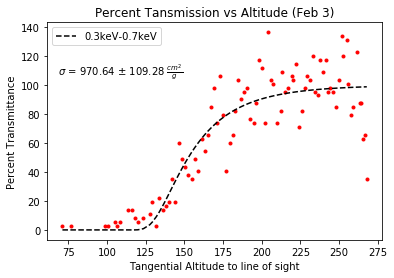

In [26]:
plt.plot(low_en.new_alt, low_en.perc_trans, 'r.')
plt.title('Percent Tansmission vs Altitude (Feb 3)')
plt.plot(low_en.new_alt, Transmit(low_en.new_alt, low_en.rho_msis, low_en.sigmafit_popt),
         'k--', label=f'{lowEn[0]/100}keV-{lowEn[1]/100}keV')
plt.ylabel('Percent Transmittance')
plt.xlabel('Tangential Altitude to line of sight')
txt = r'$\sigma$ = %.2f $\pm$ %.2f $\frac{cm^2}{g}$' % (low_en.sigmafit_popt, np.sqrt(low_en.sigmafit_pcov))
plt.figtext(0.15, 0.70, txt)
plt.legend()

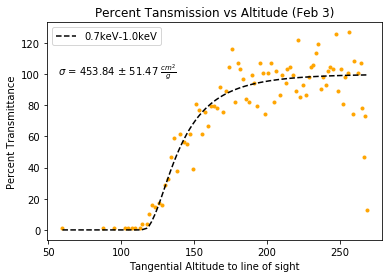

In [25]:
plt.plot(lowMid_en.new_alt, lowMid_en.perc_trans,'.', color = 'orange')
plt.title('Percent Tansmission vs Altitude (Feb 3)')
plt.plot(lowMid_en.new_alt, Transmit(lowMid_en.new_alt, lowMid_en.rho_msis, lowMid_en.sigmafit_popt),
         'k--', label=f'{lowMidEn[0]/100}keV-{lowMidEn[1]/100}keV')
plt.ylabel('Percent Transmittance')
plt.xlabel('Tangential Altitude to line of sight')
txt = r'$\sigma$ = %.2f $\pm$ %.2f $\frac{cm^2}{g}$' % (lowMid_en.sigmafit_popt, np.sqrt(lowMid_en.sigmafit_pcov))
plt.figtext(0.15, 0.70, txt)
plt.legend()
plt.savefig('0.7_1.0.png')

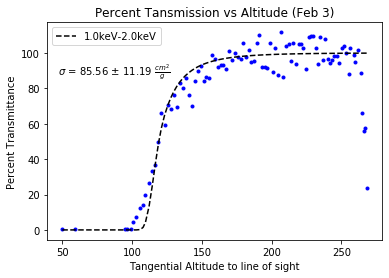

In [24]:
plt.plot(mid_en.new_alt, mid_en.perc_trans, 'b.')
plt.title('Percent Tansmission vs Altitude (Feb 3)')
plt.plot(mid_en.new_alt, Transmit(mid_en.new_alt, mid_en.rho_msis, mid_en.sigmafit_popt),
         'k--', label=f'{midEn[0]/100}keV-{midEn[1]/100}keV')
plt.ylabel('Percent Transmittance')
plt.xlabel('Tangential Altitude to line of sight')
txt = r'$\sigma$ = %.2f $\pm$ %.2f $\frac{cm^2}{g}$' % (mid_en.sigmafit_popt, np.sqrt(mid_en.sigmafit_pcov))
plt.figtext(0.15, 0.70, txt)
plt.legend()
plt.savefig('1.0_2.0.png')

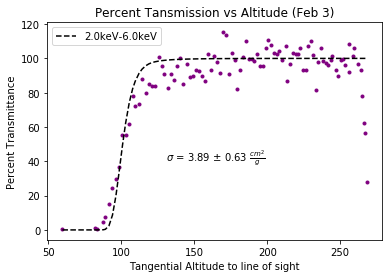

In [23]:
plt.plot(high_en.new_alt, high_en.perc_trans, '.', color = 'purple')
plt.title('Percent Tansmission vs Altitude (Feb 3)')
plt.plot(high_en.new_alt, Transmit(high_en.new_alt, high_en.rho_msis, high_en.sigmafit_popt),
         'k--', label=f'{highEn[0]/100}keV-{highEn[1]/100}keV')
plt.ylabel('Percent Transmittance')
plt.xlabel('Tangential Altitude to line of sight')
txt = r'$\sigma$ = %.2f $\pm$ %.2f $\frac{cm^2}{g}$' % (high_en.sigmafit_popt, np.sqrt(high_en.sigmafit_pcov))
plt.figtext(0.40, 0.40, txt)
plt.legend()
plt.savefig('2.0_6.0.png')

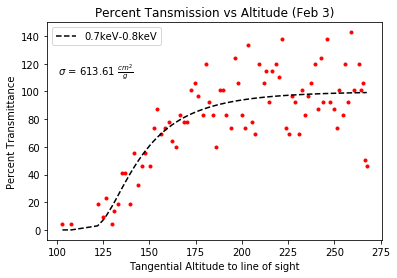

In [6]:
plt.plot(lowMid1_en.new_alt, lowMid1_en.perc_trans, 'r.')
plt.title('Percent Tansmission vs Altitude (Feb 3)')
plt.plot(lowMid1_en.new_alt, Transmit(lowMid1_en.new_alt, lowMid1_en.rho_msis, lowMid1_en.sigmafit_popt),
         'k--', label=f'{lowMidEn1[0]/100}keV-{lowMidEn1[1]/100}keV')
plt.ylabel('Percent Transmittance')
plt.xlabel('Tangential Altitude to line of sight')
plt.figtext(0.15, 0.70, r'$\sigma$ = %.2f $\frac{cm^2}{g}$' %lowMid1_en.sigmafit_popt)
plt.legend()
plt.savefig('0.7_0.8.png')

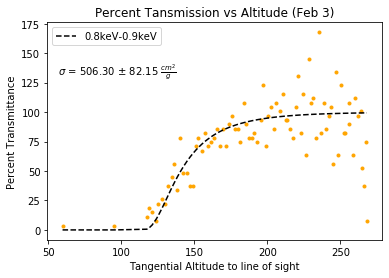

In [19]:
plt.plot(lowMid2_en.new_alt, lowMid2_en.perc_trans, '.', color = 'orange')
plt.title('Percent Tansmission vs Altitude (Feb 3)')
plt.plot(lowMid2_en.new_alt, Transmit(lowMid2_en.new_alt, lowMid2_en.rho_msis, lowMid2_en.sigmafit_popt),
         'k--', label=f'{lowMidEn2[0]/100}keV-{lowMidEn2[1]/100}keV')
plt.ylabel('Percent Transmittance')
plt.xlabel('Tangential Altitude to line of sight')
txt = r'$\sigma$ = %.2f $\pm$ %.2f $\frac{cm^2}{g}$' % (lowMid2_en.sigmafit_popt, np.sqrt(lowMid2_en.sigmafit_pcov))
plt.figtext(0.15, 0.70, txt)
plt.legend()
plt.savefig('0.8_0.9.png')

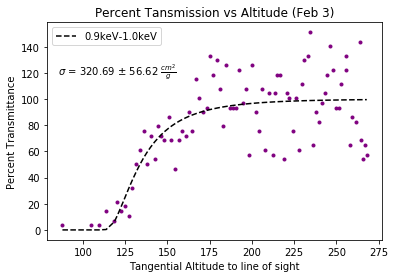

In [20]:
plt.plot(lowMid3_en.new_alt, lowMid3_en.perc_trans, '.', color = 'purple')
plt.title('Percent Tansmission vs Altitude (Feb 3)')
plt.plot(lowMid3_en.new_alt, Transmit(lowMid3_en.new_alt, lowMid3_en.rho_msis, lowMid3_en.sigmafit_popt),
         'k--', label=f'{lowMidEn3[0]/100}keV-{lowMidEn3[1]/100}keV')
plt.ylabel('Percent Transmittance')
plt.xlabel('Tangential Altitude to line of sight')
txt = r'$\sigma$ = %.2f $\pm$ %.2f $\frac{cm^2}{g}$' % (lowMid3_en.sigmafit_popt, np.sqrt(lowMid3_en.sigmafit_pcov))
plt.figtext(0.15, 0.70, txt)
plt.legend()
plt.savefig('0.9_1.0.png')

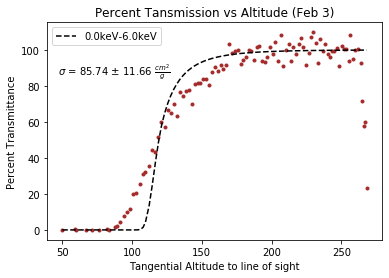

In [17]:
plt.plot(all_en.new_alt, all_en.perc_trans, '.', color = 'brown')
plt.title('Percent Tansmission vs Altitude (Feb 3)')
plt.plot(all_en.new_alt, Transmit(all_en.new_alt, all_en.rho_msis, all_en.sigmafit_popt),
         'k--', label=f'{allEn[0]/100}keV-{allEn[1]/100}keV')
plt.ylabel('Percent Transmittance')
plt.xlabel('Tangential Altitude to line of sight')
txt = r'$\sigma$ = %.2f $\pm$ %.2f $\frac{cm^2}{g}$' % (all_en.sigmafit_popt, np.sqrt(all_en.sigmafit_pcov))
plt.figtext(0.15, 0.70, txt)
plt.legend()
plt.savefig('0.0_6.0.png')

In [10]:
sigmalist = [low_en.sigmafit_popt, lowMid1_en.sigmafit_popt, lowMid2_en.sigmafit_popt,
            lowMid3_en.sigmafit_popt, mid_en.sigmafit_popt, high_en.sigmafit_popt]
energylist = [np.mean(low_en.energies), np.mean(lowMid1_en.energies), np.mean(lowMid2_en.energies),
                     np.mean(lowMid3_en.energies), np.mean(mid_en.energies), np.mean(high_en.energies)]

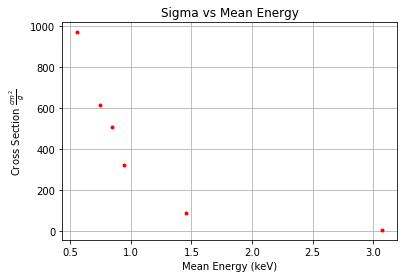

In [11]:
plt.plot(energylist, sigmalist, 'r.')
plt.title('Sigma vs Mean Energy')
plt.xlabel('Mean Energy (keV)')
plt.ylabel(r'Cross Section $\frac{cm^2}{g}$')
plt.grid()

2.779798831036391e-07

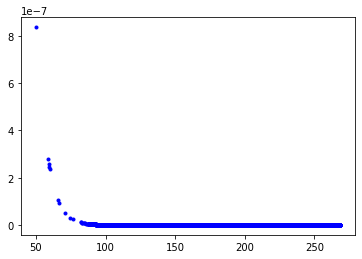

In [30]:
plt.plot(altArray, msisRho, 'b.')
msisRho[1]

Text(0.5, 1.0, 'Temperature vs Altitude')

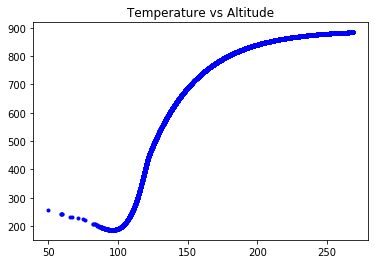

In [3]:
plt.plot(altArray, msisT, 'b.')
plt.title('Temperature vs Altitude')